In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import py_wake
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math


from py_wake.wind_farm_models import All2AllIterative
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.flow_map import XZGrid
from py_wake.flow_map import YZGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.turbulence_models import GCLTurbulence
from py_wake.deficit_models import Rathmann
from py_wake.utils.plotting import setup_plot

from py_wake.site import UniformWeibullSite

from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine

from py_wake.deficit_models.gaussian import BlondelSuperGaussianDeficit2020
from py_wake.literature.gaussian_models import Blondel_Cathelain_2020

from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing
from sko.GA import GA


import h5py
import xarray as xr

import time


In [2]:
#turbine parameters
D = 283.21 #rotor diameter
H=170 #hub height
Prated=22000 #kW

WD=270  #wind direction
WS=9 #wind speed
YD=0   #yaw direction
TI=0 #turbulence intensity


#site
site= UniformWeibullSite(p_wd=[0.03597152, 0.03948682, 0.05167394999999999, 0.07000154, 0.08364547,0.0643485,0.08643194,0.1177051,0.1515757, 0.14737920000000002, 0.1001205 , 0.1001205],  # sector frequencies
                               a=[9.176929, 9.782334, 9.531809,9.909545, 10.04269, 9.593921, 9.584007, 10.51499, 11.39895, 11.68746,11.63732,10.08803],          # Weibull scale parameter
                               k=[ 2.392578,2.447266,2.412109,2.591797, 2.755859, 2.595703, 2.583984,2.548828, 2.470703,2.607422, 2.626953, 2.326172],          # Weibull shape parameter
                               ti=TI                          # turbulence intensity, optional
                               )




In [3]:
from wind_turbine_object import create_wind_turbine 
amplitude=2
windTurbines = create_wind_turbine(amplitude, D, H)


simulation_data_xy = np.loadtxt('103_helix_2deg_xy.1.txt')

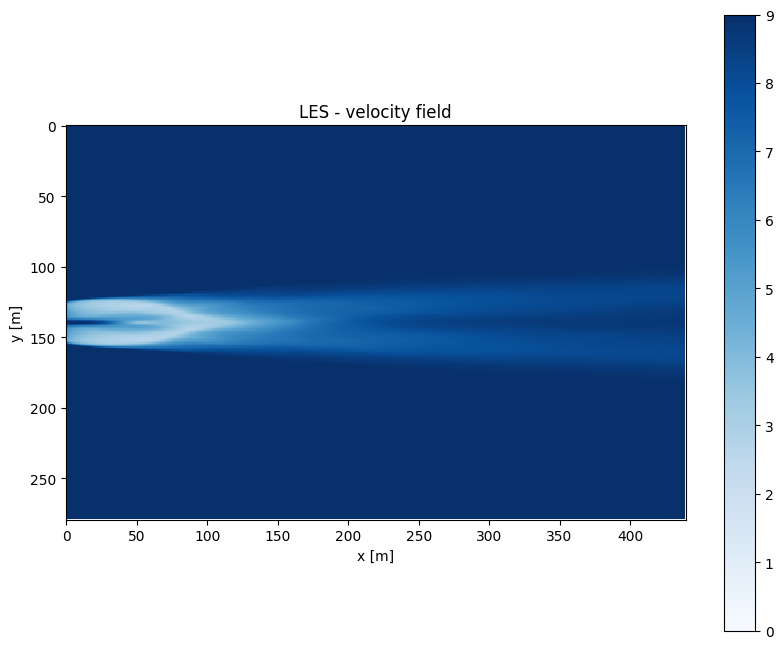

In [4]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(simulation_data_xy, cmap='Blues', interpolation='nearest', vmin=0, vmax=WS)
plt.colorbar()  
plt.title('LES - velocity field')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

In [5]:
def get_velocity_field_xy(model=None, grid=XYGrid(x=np.linspace(0, 4400, 440), y=np.linspace(-1400 ,1400, 280), h=H)):
    wfm = All2AllIterative(site, windTurbines, wake_deficitModel=model,blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
    result = wfm(x=[0], y=[0], wd=WD, ws=WS, yaw=YD).flow_map(grid)
    return result.WS_eff.values.squeeze()



In [6]:
wf_model2=Blondel_Cathelain_2020(site,windTurbines,turbulenceModel=GCLTurbulence())
sim_res = wf_model2(x=[0], y=[0],     # wind turbine positions
                   h=H,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0,   # Wind turbine types
                   wd=WD,  # Wind direction
                   ws=WS,  # Wind speed
                  )

CT=sim_res.CT.values.squeeze()

In [ ]:
#XY

import time
#hyperparameters may need to be modified maxiter_best=150 popsize_best=150 is a good original guess. improve for more refined results

maxiter_best=150
popsize_best=150
tol_best=1E-06
seed_best=42
mutation_best=1.5
recombination_best=0.7
strategy_best= 'best1bin'

x_tilde=1/D * np.linspace(0, 4400, 440)
x_tilde_matrix = np.tile(x_tilde, (280, 1))

def objective_function_xy(params):
    b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  
    a_s=0
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()

    
    beta=0.5 * (1+np.sqrt(1-CT))/(np.sqrt(1-CT))
    sigma=(a_s *TI + b_s) * x_tilde_matrix.ravel() + c_s * np.sqrt(beta)
    n = 3.11 * np.exp(b_f * x_tilde) + c_f

    tot = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    if math.isnan(tot):
        return 10**36

    else:
        if np.any(sigma < 0) or np.any(n < 2) :
            return 10**36
        else:
            return tot


initial_params = None
bounds =[ (0,2), (0, 2), (-2, 0), (0, 5)]
start_time=time.time()

result = differential_evolution(objective_function_xy, bounds, strategy=strategy_best, maxiter=maxiter_best, popsize=int(popsize_best), tol=tol_best, mutation=mutation_best, recombination=recombination_best, seed=seed_best, x0=initial_params)
end_time=time.time()
elapsed_time=end_time-start_time
print(f"Elapsed Time: {elapsed_time} seconds")

termination_message = result.message
print(f"Termination message: {termination_message}")

optimized_params_xy = result.x
optimal_function_xy = result.fun
print("Best Solution:", optimized_params_xy)
print("Best Objective Value:", optimal_function_xy)

#local refinement
from scipy.optimize import least_squares

def objective_function_LS(params):
    b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  
    a_s=0
    
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()
    
    beta=0.5 * (1+np.sqrt(1-CT))/(np.sqrt(1-CT))
    sigma=(a_s *TI + b_s) * x_tilde_matrix.ravel() + c_s * np.sqrt(beta)
    n = 3.11 * np.exp(b_f * x_tilde) + c_f

    tot = np.sum(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    if math.isnan(tot) :
        return np.array([10**18], dtype=float) 

    else:
        return np.array([tot], dtype=float)

    

result_refinement_DE5 = least_squares(objective_function_LS, x0=optimized_params_xy)
optimized_params_DE5_refined_xy=result_refinement_DE5.x
print("Best Solution (a):", optimized_params_DE5_refined_xy)
print("Best Objective Value:", result_refinement_DE5.fun) #keep in mind that it's different


np.savetxt('103_helix_2deg_params_newpow.txt',optimized_params_DE5_refined_xy)
result=objective_function_xy(optimized_params_DE5_refined_xy)
np.savetxt('103_helix_2deg_sol_newpow.txt',result)


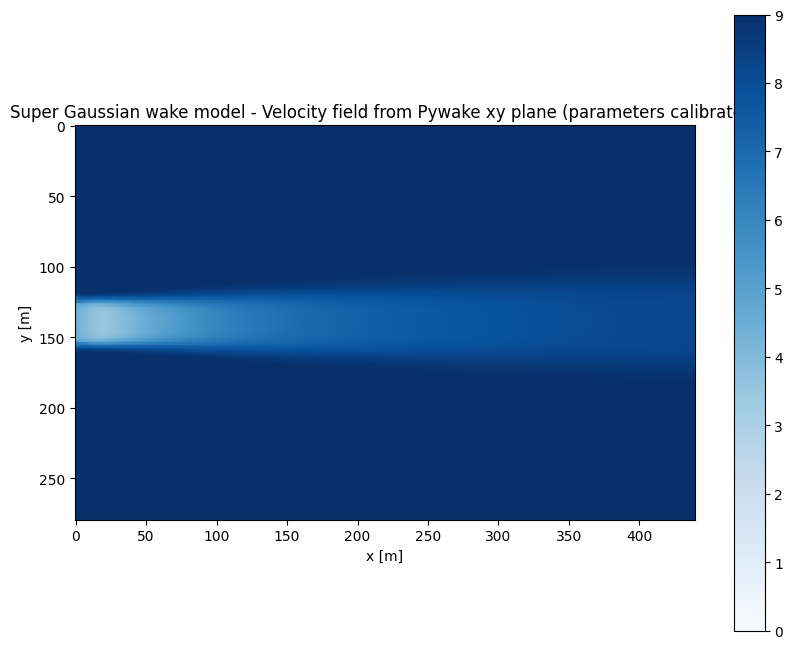

In [ ]:
#plot
optimized_params_DE=optimized_params_DE5_refined_xy
wf_model_optimized_DE=BlondelSuperGaussianDeficit2020(a_s=0, b_s=optimized_params_DE[0], c_s=optimized_params_DE[1], b_f=optimized_params_DE[2], c_f=optimized_params_DE[3])

velocity_final_DE_xy=get_velocity_field_xy(wf_model_optimized_DE)

fig = plt.figure(figsize=(10, 8))
plt.imshow(velocity_final_DE_xy, cmap='Blues', interpolation='nearest', vmin=0, vmax=WS)
plt.colorbar()  
plt.title('Super Gaussian wake model - Velocity field from Pywake xy plane (parameters calibrated)')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

